# Desafio 02 - Link Prediction

## Bibliotecas

In [2]:
import networkx as nx
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt


%matplotlib inline

## Carregando Arquivos

In [3]:
G = nx.read_gml("./../data_desafio/GraphMissingEdges.gml")

In [4]:
categories_nodes = nx.get_node_attributes(G,'categories')
for key in categories_nodes:
    categories_nodes[key] = categories_nodes[key].split(',')

In [5]:
categories_df = pd.read_csv('./../data_desafio/categories.csv', sep=',')
categories_df = categories_df.set_index('CategoryId')

In [6]:
for node in G.nodes:
    categories = categories_nodes[node]
    categories_names = []
    for category in categories:
        if category != '':
            categories_names.append(categories_df.loc[int(category)]['names'])
    G.nodes[node]['categories_named'] = categories_names

## Informações sobre o Grafo

In [7]:
pos = nx.spring_layout(G)
nx.draw(G, cmap = plt.get_cmap('rainbow'), pos=pos, node_size=10, with_labels=False, edge_color='grey', width=0.1)

n = G.number_of_nodes()
m = G.number_of_edges()
print("Número de nós : %d" % n)
print("Número de arestas : %d" % m)
print("Número de componentes conectados : %d" % nx.number_connected_components(G))

KeyboardInterrupt: 

In [8]:
proportion_edges = 0.2
edge_subset = random.sample(sorted(G.edges()), int(proportion_edges * G.number_of_edges()))

G_train = G.copy()
G_train.remove_edges_from(edge_subset)

In [ ]:
plt.figure(figsize=(12,8))
nx.draw(G_train)
plt.gca().collections[0].set_edgecolor("#000000") 

In [7]:
edge_subset_size = len(list(edge_subset))
print("Número de arestas removidas : %d" % edge_subset_size)
print("Número de arestas restantes : %d" % (m - edge_subset_size))

Número de arestas removidas : 3798


NameError: name 'm' is not defined

### Jaccard Coeefficient

In [ ]:
# Fazendo previsões com o jaccard
pred_jaccard = nx.jaccard_coefficient(G_train)

pred_jaccard_list = list(pred_jaccard)

print("Número de previsões : %d" % len(pred_jaccard_list))

jaccard_df = pd.DataFrame(pred_jaccard_list, columns=['node1', 'node2', 'score'])
jaccard_df = jaccard_df.sort_values(by='score', ascending=False)

jaccard_df['label'] = jaccard_df.apply(lambda row: (row['node1'], row['node2']) in edge_subset, axis=1)


# Computa o AUC score da curva ROC
fpr_jaccard, tpr_jaccard, _ = metrics.roc_curve(jaccard_df['label'], jaccard_df['score'])
auc_jaccard = roc_auc_score(jaccard_df['label'], jaccard_df['score'])


#Gráfico da curva ROC
plt.title('ROC')
plt.plot(fpr_jaccard, tpr_jaccard, 'b', label = 'AUC = %0.2f' % auc_jaccard)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Taxa Verdadeiro Positivo')
plt.xlabel('Taxa de Falso Positivo')
plt.show()

In [60]:
print("Número de previsões : %d" % len(pred_jaccard_list))

Número de previsões : 10448156


### Preferential Attachment 

Número de previsões : %d 10448162
0.8719047126042729


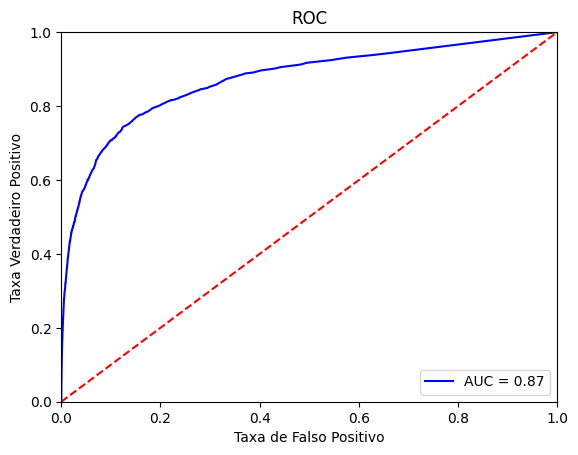

In [8]:
pred_prefAtch = nx.preferential_attachment(G_train)

pred_prefAtch_list = list(pred_prefAtch)

print("Número de previsões : %d", len(pred_prefAtch_list))

prefAtch_df = pd.DataFrame(pred_prefAtch_list, columns=['node1', 'node2', 'score'])
prefAtch_df = prefAtch_df.sort_values(by='score', ascending=False)

prefAtch_df['label'] = prefAtch_df.apply(lambda row: (row['node1'], row['node2']) in edge_subset, axis=1)

# Computa o AUC score da curva ROC
fpr_prefAtch, tpr_prefAtch, thresholds = metrics.roc_curve(prefAtch_df['label'], prefAtch_df['score'])
auc_prefAtch = roc_auc_score(prefAtch_df['label'], prefAtch_df['score'])
print(auc_prefAtch)

#Gráfico da curva ROC
plt.title('ROC')
plt.plot(fpr_prefAtch, tpr_prefAtch, 'b', label = 'AUC = %0.2f' % auc_prefAtch)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Taxa Verdadeiro Positivo')
plt.xlabel('Taxa de Falso Positivo')
plt.show()

In [9]:
#save results to csv 

prefAtch_df.to_csv('./../data_desafio/pref.csv', index=False)

In [9]:
prefAtch_df = pd.read_csv('./../data_desafio/pref.csv', sep=',')

In [ ]:
fpr_prefAtch, tpr_prefAtch, thresholds = metrics.roc_curve(prefAtch_df['label'], prefAtch_df['score'])
auc_prefAtch = roc_auc_score(prefAtch_df['label'], prefAtch_df['score'])


thresholds_df  = pd.DataFrame({'thresholds': thresholds, 'fpr': fpr_prefAtch, 'tpr': tpr_prefAtch})
thresholds_df['fnr'] = 1 - thresholds_df['tpr']
thresholds_df["f1_score"] = (2 * thresholds_df["tpr"])/(2*thresholds_df["tpr"] + thresholds_df["fpr"] +thresholds_df["fnr"])

thresholds_df = thresholds_df.sort_values(by='f1_score', ascending=False)


In [ ]:
# save the threshold to csv

thresholds_df.to_csv('./../data_desafio/thresholds.csv', index=False)


In [10]:
thresholds_df = pd.read_csv('./../data_desafio/thresholds.csv', sep=',')

In [11]:
# add predicted edges to the graph

prefAtch_list = prefAtch_df.values.tolist()

G_pred = G_train.copy()

for edge in prefAtch_list:
    G_pred.add_edge(edge[0], edge[1], score=edge[2])


In [12]:

edges_evaluate_df =  pd.read_csv('./../data_desafio/edgesToEvaluate.csv', sep=',')

In [13]:
edges = G_pred.edges()
        

In [15]:
#get the scores of the edges to evaluate

edges_evaluate_df['score'] = edges_evaluate_df.apply(lambda row: G_pred[row['node1']][row['node2']]['score'] if (row['node1'], row['node2']) in edges else -1, axis=1)

In [16]:
edges_evaluate_df = edges_evaluate_df.sort_values(by='score', ascending=False)

In [19]:
better_threshold = thresholds_df.iloc[0]['thresholds']

In [20]:
results_df = pd.DataFrame(columns=['linkID', 'link'])

for index, row in edges_evaluate_df.iterrows():
    hasLink = 0
    if row['score'] >= better_threshold:
        hasLink = 1
    results_df = pd.concat([results_df, pd.DataFrame([[row['linkID'], hasLink]], columns=['linkID', 'link'])])
        

In [22]:
results_df.to_csv('./../data_desafio/results.csv', index=False)

### Resource Allocation

Número de previsões : 10448156
0.7455749928422375


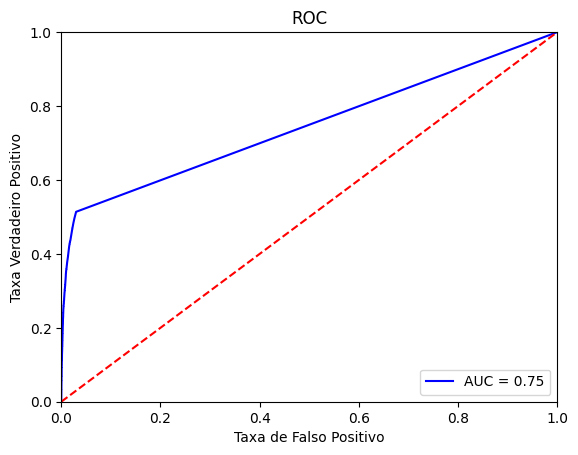

In [42]:
pred_ra = nx.resource_allocation_index(G_train)

pred_ra_list = list(pred_ra)

print("Número de previsões : %d" % len(pred_ra_list))

ra_df = pd.DataFrame(pred_ra_list, columns=['node1', 'node2', 'score'])
ra_df = ra_df.sort_values(by='score', ascending=False)

ra_df['label'] = ra_df.apply(lambda row: (row['node1'], row['node2']) in edge_subset, axis=1)

# Computa o AUC score da curva ROC
fpr_ra, tpr_ra, _ = metrics.roc_curve(ra_df['label'], ra_df['score'])
auc_ra = roc_auc_score(ra_df['label'], ra_df['score'])
print(auc_ra)


#Gráfico da curva ROC
plt.title('ROC')
plt.plot(fpr_ra, tpr_ra, 'b', label = 'AUC = %0.2f' % auc_ra)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Taxa Verdadeiro Positivo')
plt.xlabel('Taxa de Falso Positivo')
plt.show()

### Common Neighbor Centrality

Número de previsões : 10448159
0.8623598782198487


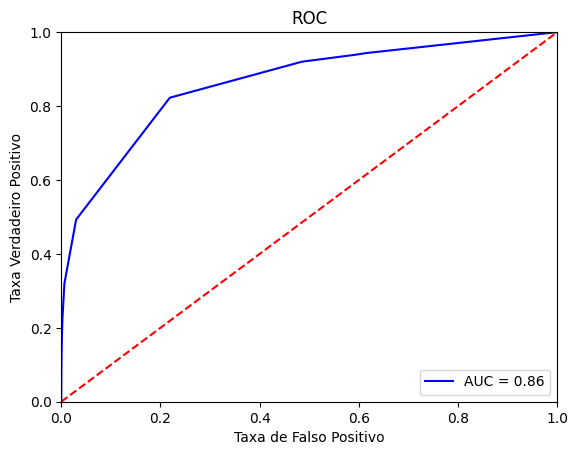

In [23]:
pred_CNC = nx.common_neighbor_centrality(G_train)
pred_CNC_list = list(pred_CNC)

print("Número de previsões : %d" % len(pred_CNC_list))

CNC_df = pd.DataFrame(pred_CNC_list, columns=['node1', 'node2', 'score'])
CNC_df = CNC_df.sort_values(by='score', ascending=False)

CNC_df['label'] = CNC_df.apply(lambda row: (row['node1'], row['node2']) in edge_subset, axis=1)

# Computa o AUC score da curva ROC
fpr_CNC, tpr_CNC, _ = metrics.roc_curve(CNC_df['label'], CNC_df['score'])
auc_CNC = roc_auc_score(CNC_df['label'], CNC_df['score'])
print(auc_CNC)

#Gráfico da curva ROC
plt.title('ROC')
plt.plot(fpr_CNC, tpr_CNC, 'b', label = 'AUC = %0.2f' % auc_CNC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Taxa Verdadeiro Positivo')
plt.xlabel('Taxa de Falso Positivo')
plt.show()

In [24]:
# save to csv

CNC_df.to_csv('./../data_desafio/CNC.csv', index=False)

In [26]:
fpr_CNC, tpr_CNC, thresholds = metrics.roc_curve(CNC_df['label'], CNC_df['score'])
auc_prefAtch = roc_auc_score(prefAtch_df['label'], prefAtch_df['score'])


thresholds_cnc_df  = pd.DataFrame({'thresholds': thresholds, 'fpr': fpr_CNC, 'tpr': tpr_CNC})
thresholds_cnc_df['fnr'] = 1 - thresholds_cnc_df['tpr']
thresholds_cnc_df["f1_score"] = (2 * thresholds_cnc_df["tpr"])/(2*thresholds_cnc_df["tpr"] + thresholds_cnc_df["fpr"] +thresholds_cnc_df["fnr"])

thresholds_cnc_df = thresholds_cnc_df.sort_values(by='f1_score', ascending=False)

In [27]:
# save the threshold to csv

thresholds_cnc_df.to_csv('./../data_desafio/thresholds_cnc.csv', index=False)

In [28]:
cnc_list = CNC_df.values.tolist()

G_pred = G_train.copy()

for edge in cnc_list:
    G_pred.add_edge(edge[0], edge[1], score=edge[2])


In [29]:
edges = G_pred.edges()

In [30]:
edges_evaluate_df['score'] = edges_evaluate_df.apply(lambda row: G_pred[row['node1']][row['node2']]['score'] if (row['node1'], row['node2']) in edges else -1, axis=1)
edges_evaluate_df = edges_evaluate_df.sort_values(by='score', ascending=False)

In [31]:
better_threshold = thresholds_cnc_df.iloc[0]['thresholds']

In [32]:
better_threshold

304.99999999999994

In [33]:
results_df = pd.DataFrame(columns=['linkID', 'link'])

for index, row in edges_evaluate_df.iterrows():
    hasLink = 0
    if row['score'] >= better_threshold:
        hasLink = 1
    results_df = pd.concat([results_df, pd.DataFrame([[row['linkID'], hasLink]], columns=['linkID', 'link'])])
        

In [34]:
results_df.to_csv('./../data_desafio/results_cnc.csv', index=False)

### Adamic Adar

0.7348797105184496


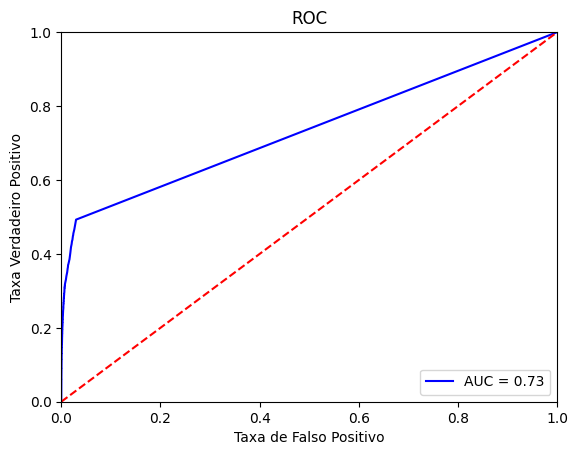

In [16]:
pred_adamic = list(nx.adamic_adar_index(G_train))

score_adamic = [s for (u,v,s) in pred_adamic]

label_adamic = [(u,v) in edge_subset for (u,v,s) in pred_adamic]

fpr_adamic, tpr_adamic, _ = metrics.roc_curve(label_adamic, score_adamic)
auc_adamic = roc_auc_score(label_adamic, score_adamic)
print(auc_adamic)


#Gráfico da curva ROC
plt.title('ROC')
plt.plot(fpr_adamic, tpr_adamic, 'b', label = 'AUC = %0.2f' % auc_adamic)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Taxa Verdadeiro Positivo')
plt.xlabel('Taxa de Falso Positivo')
plt.show()

### Comparação entre os modelos

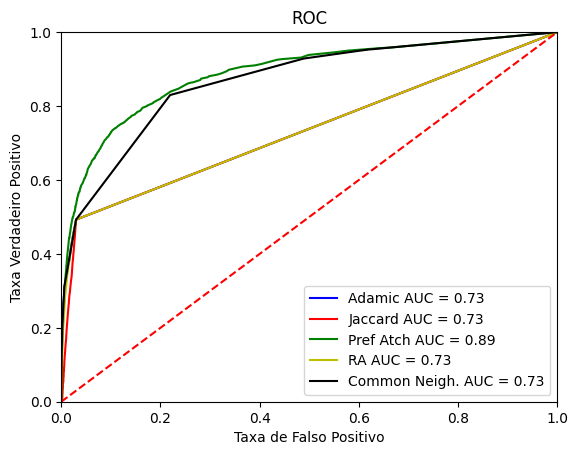

In [17]:
plt.title('ROC')
plt.plot(fpr_adamic, tpr_adamic, 'b', label = 'Adamic AUC = %0.2f' % auc_adamic)
plt.plot(fpr_jaccard, tpr_jaccard, 'r', label = 'Jaccard AUC = %0.2f' % auc_jaccard)
plt.plot(fpr_prefAtch, tpr_prefAtch, 'g', label = 'Pref Atch AUC = %0.2f' % auc_prefAtch)
plt.plot(fpr_ra, tpr_ra, 'y', label = 'RA AUC = %0.2f' % auc_ra)
plt.plot(fpr_CNC, tpr_CNC, 'k', label = 'Common Neigh. AUC = %0.2f' % auc_ra)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Taxa Verdadeiro Positivo')
plt.xlabel('Taxa de Falso Positivo')
plt.show()

In [9]:

A = nx.adjacency_matrix(G)
A.shape



C:\Users\rodri\AppData\Local\Temp\ipykernel_15944\2297324554.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


(4575, 4575)

In [12]:
# para guardar todos os pares de nós não conectados 
listUnconnected = []

# Varre a matriz de adjacência procurando por pares desconectados
offset = 0
for i in tqdm(range(A.shape[0])):
    for j in range(offset,A.shape[1]):
        if i != j:
            if A[i,j] == 0:
                listUnconnected.append([i,j])

    offset +=1



100%|██████████| 4575/4575 [02:10<00:00, 35.19it/s] 


In [13]:
unlinked1 = [i[0] for i in listUnconnected]
unlinked2 = [i[1] for i in listUnconnected]

dfPairs = pd.DataFrame({'node1':unlinked1, 
                     'node2':unlinked2})

# cria a variável 'link', onde 0= sem link e 1 com link
dfPairs['link'] = 0
dfPairs

,node1,node2,link
0,0,1,0
1,0,2,0
2,0,3,0
3,0,4,0
4,0,5,0
...,...,...,...
10444436,4571,4573,0
10444437,4571,4574,0
10444438,4572,4573,0
10444439,4572,4574,0


In [20]:
df = pd.DataFrame(edge_subset, columns=['node1', 'node2'])
df['link'] = 1

dfPairs = pd.concat([df,dfPairs])

,node1,node2,link
0,IUywieKL-xOm3tFJEY8fOw,X88w0XrUSIKue9Vuwtqs_g,1
1,QqbZA4r5g1vCbOxOAKJgWg,VpsXhgaBA7-65Gt2zg8Nkg,1
2,azE1DNVQFBU8boVbaJhj7w,4iSVxQKK1G3V-LBffQxaKg,1
3,7z2x16M7IuG8KPfMsyVrKA,haQkLoAcdUBvLteoY6NnJA,1
4,Eg_M8eeu9SDEdbP7iUmVbQ,caGXS6ubNTlv91ZZyoirjQ,1
...,...,...,...
3793,iuOK9_SBaJ5y0xzu4Fy4IQ,aU3MBJ3Cq5yip6JTyJi7KQ,1
3794,4mYS-4UOjTKgsf0tX1_IkQ,HPX1pRtWInt_UVtfld-zsQ,1
3795,BY1_pf7FHUycHOwYEenDlQ,_vzNvnj8ob0hAk2QXEv3Mw,1
3796,qXGKYRwCR9SLgLl0g_9o5g,oeW0vIYd3rUnAPgmD4fEFg,1


In [21]:
dfPairs

,node1,node2,link
0,IUywieKL-xOm3tFJEY8fOw,X88w0XrUSIKue9Vuwtqs_g,1
1,QqbZA4r5g1vCbOxOAKJgWg,VpsXhgaBA7-65Gt2zg8Nkg,1
2,azE1DNVQFBU8boVbaJhj7w,4iSVxQKK1G3V-LBffQxaKg,1
3,7z2x16M7IuG8KPfMsyVrKA,haQkLoAcdUBvLteoY6NnJA,1
4,Eg_M8eeu9SDEdbP7iUmVbQ,caGXS6ubNTlv91ZZyoirjQ,1
...,...,...,...
10444436,4571,4573,0
10444437,4571,4574,0
10444438,4572,4573,0
10444439,4572,4574,0


In [22]:
from node2vec import Node2Vec

# Gera caminhos 
node2vec = Node2Vec(G_train, dimensions=100, walk_length=16, num_walks=50)

# treina o modelo node2vec
n2w_model = node2vec.fit(window=7, min_count=1)

Computing transition probabilities:   0%|          | 0/4575 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:13<00:00,  3.82it/s]


In [23]:
#representa as arestas pela soma dos embeddings dos nós
featuresPares = [(n2w_model.wv[str(i)]+n2w_model.wv[str(j)]) for i,j in zip(dfPairs['node1'], dfPairs['node2'])]

KeyError: "Key '0' not present"